Start Session inicio de leitura raw

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, to_timestamp,split,count, year, month


In [0]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Bronze - Sales") \
    .getOrCreate()

Leitura do Arquivo de Vendas

In [0]:
df = spark.read\
      .option("header","true")\
      .option("delimiter",",")\
      .option("inferSchema", False) \
      .csv('dbfs:/FileStore/')
df.count()

44500

Salvar o arquivo em formato otimizado

In [0]:
_dirBronze = 'dbfs:/bronze'
df.write.parquet(_dirBronze,mode='overwrite')
#Criação do Parquet com os dados que foram lidos da base raw

fazer a leitura para iniciar tratamentos 

In [0]:
# prompt: ler dados pasta bronze
df_Sil = spark.read.parquet(_dirBronze)
df_Sil.show()

+--------------------+--------------------+----------+---------+-------+---------+-------+--------------------+--------------------+--------------------+
|                name|             sale_id|product_id|  product|price_y| quantity|price_x|          created_at|          updated_at|               email|
+--------------------+--------------------+----------+---------+-------+---------+-------+--------------------+--------------------+--------------------+
|        Mason Howell|442bc2f0-22d3-3c8...|       296|Lang Club|866.694|   3.8999| 2433.8|1997-09-17 21:50:...|2007-02-15 19:34:...|jessica.cole@exam...|
|        Mason Howell|442bc2f0-22d3-3c8...|       296|Lang Club|866.694|      4.0|1196.58|1997-09-17 21:50:...|2007-02-15 19:34:...|jessica.cole@exam...|
|        Mason Howell|442bc2f0-22d3-3c8...|       296|Lang Club|866.694|  1.38452| 1975.0|1997-09-17 21:50:...|2007-02-15 19:34:...|jessica.cole@exam...|
|        Mason Howell|442bc2f0-22d3-3c8...|       296|Lang Club|866.694|    

Separação de Ano e Mês da criação do registro de venda e user 

In [0]:

# Calcular o total de cada venda
df_Sil = df_Sil.withColumn("total_sale", col("price_x") * col("quantity"))

# Extrair ano e mês da coluna "created_at"
df_Sil = df_Sil.withColumn("year_created", col("created_at").substr(1, 4).cast("int"))
df_Sil = df_Sil.withColumn("month_created", col("created_at").substr(6, 2).cast("int"))

# trair usuario que realizou a operação
df_Sil = df_Sil.withColumn('user',split(col("email"), "@")[0] )
# Exibir DataFrame após transformações
df_Sil.show()

+--------------------+--------------------+----------+---------+-------+---------+-------+--------------------+--------------------+--------------------+------------------+------------+-------------+------------------+
|                name|             sale_id|product_id|  product|price_y| quantity|price_x|          created_at|          updated_at|               email|        total_sale|year_created|month_created|              user|
+--------------------+--------------------+----------+---------+-------+---------+-------+--------------------+--------------------+--------------------+------------------+------------+-------------+------------------+
|        Mason Howell|442bc2f0-22d3-3c8...|       296|Lang Club|866.694|   3.8999| 2433.8|1997-09-17 21:50:...|2007-02-15 19:34:...|jessica.cole@exam...| 9491.576620000002|        1997|            9|      jessica.cole|
|        Mason Howell|442bc2f0-22d3-3c8...|       296|Lang Club|866.694|      4.0|1196.58|1997-09-17 21:50:...|2007-02-15 19

realizando analises de alguns indicadores do df

In [0]:
df_Sil.describe().show()

product_counts = df_Sil.groupBy("product") \
                   .agg(count("*").alias("count")) \
                   .orderBy("count", ascending=False)

product_counts.show()

total_sales_by_year = df_Sil.groupBy("year_created")\
                        .sum("total_sale") \
                        .orderBy("year_created")\


total_sales_by_year = total_sales_by_year.withColumnRenamed('sum(total_sale)', "TotalVendas")

T5_per_user = df_Sil.groupBy("user")\
                        .sum("total_sale")\
                        .orderBy(col('sum(total_sale)'), ascending=False) \
                        .limit(5)
T5_per_user = T5_per_user.withColumnRenamed('sum(total_sale)', "TotalVendas")

T5_per_user.show()
total_sales_by_year.show()


+-------+--------------+--------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+------+
|summary|          name|             sale_id|       product_id|           product|           price_y|          quantity|           price_x|          created_at|          updated_at|             email|       total_sale|      year_created|     month_created|  user|
+-------+--------------+--------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+------+
|  count|         44500|               44500|            44500|             44500|             44500|             44500|             44500|               44500|               44500|             44500|        

Armazenando df agregados e df main 

In [0]:
_dirSilver = 'dbfs:/Silver'

# salvar em parquet os df agregados 

df_Sil.write.parquet(_dirSilver+'/parquet/sales',mode='overwrite')
product_counts.write.parquet(_dirSilver+'/parquet/product_counts',mode='overwrite')
total_sales_by_year.write.parquet(_dirSilver+'/parquet/total_sales',mode='overwrite')
T5_per_user.write.parquet(_dirSilver+'/parquet/T5_per_user',mode='overwrite')
# salvar em Delta o df main
df_Sil.write.format("delta").mode("overwrite").save(_dirSilver+'/delta/sales') 

Mostrando resultado de vendas por anos

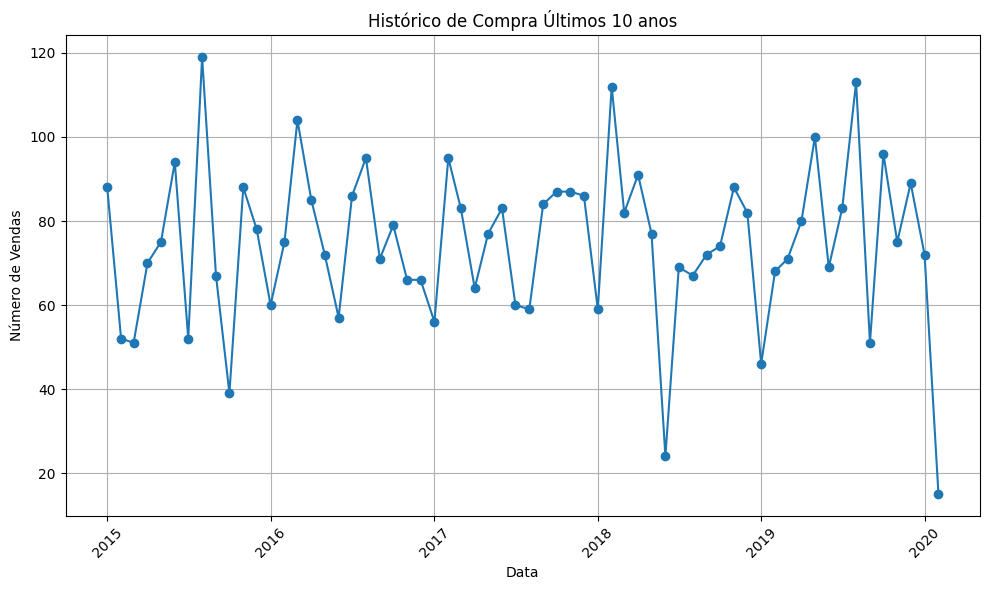

In [0]:

_dirGold = 'dbfs:/Gold'
df_gold = spark.read.parquet(_dirSilver+'/parquet/sales')

# Extrair ano e mês da coluna 'created_at'
df_gold = df_gold.withColumn("year_month", col("created_at").substr(1, 7))
# Filtrar para incluir apenas os últimos 10 anos
current_year =  pd.Timestamp.now().year
start_year = current_year - 9  # Últimos 10 anos
df_filtered = df_gold.filter(year("created_at") >= start_year)

# Calcular o total de vendas por ano-mês
sales_by_month = df_filtered.groupBy("year_month").count().orderBy("year_month")

# Converter DataFrame para Pandas para plotagem
sales_pandas = sales_by_month.toPandas()

# Converter a coluna 'year_month' para tipo de data
sales_pandas["year_month"] = pd.to_datetime(sales_pandas["year_month"])

plt.figure(figsize=(10, 6))
plt.plot(sales_pandas["year_month"], sales_pandas["count"], marker='o')
plt.title("Histórico de Compra Últimos 10 anos")
plt.xlabel("Data")
plt.ylabel("Número de Vendas")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
#Manter o df final com os tratamentos na camada gold
df_gold.write.parquet(_dirGold+'/parquet/',mode='overwrite')


Separação de dados para ML

In [0]:
df_gold = df_gold.withColumn("price_x", col("price_x").cast("int"))
df_gold = df_gold.withColumn("quantity", col("quantity").cast("int"))
df_gold.printSchema()


root
 |-- name: string (nullable = true)
 |-- sale_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product: string (nullable = true)
 |-- price_y: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price_x: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- email: string (nullable = true)
 |-- total_sale: double (nullable = true)
 |-- year_created: integer (nullable = true)
 |-- month_created: integer (nullable = true)
 |-- user: string (nullable = true)
 |-- year_month: string (nullable = true)



Criação do Modelo de LR

In [0]:
df_selected = df_gold.select(df_gold["price_x"].alias("price_x"), "quantity").na.drop(subset=["quantity","price_x"])

# Criar um vetor de features
vectorAssembler = VectorAssembler(inputCols=["price_x"], outputCol="features")

df_features = vectorAssembler.transform(df_selected).select("features", "quantity")

(train_data, test_data) = df_features.randomSplit([0.6, 0.4], seed=999)

# Criar e treinar o modelo de regressão linear
lr = LinearRegression(featuresCol="features", labelCol="quantity")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)
predictions_df = predictions.select("features", "quantity", "prediction")

In [0]:
predictions_df.show()

+--------+--------+------------------+
|features|quantity|        prediction|
+--------+--------+------------------+
|   [0.0]|       4| 2.057845978826463|
|   [0.0]|       2| 2.057845978826463|
|   [0.0]|       3| 2.057845978826463|
|   [1.0]|       3| 2.057852108740053|
|   [1.0]|       0| 2.057852108740053|
|   [2.0]|       0|2.0578582386536435|
|   [2.0]|       1|2.0578582386536435|
|   [2.0]|       4|2.0578582386536435|
|   [3.0]|       1|2.0578643685672335|
|   [3.0]|       1|2.0578643685672335|
|   [3.0]|       1|2.0578643685672335|
|   [3.0]|       2|2.0578643685672335|
|   [3.0]|       4|2.0578643685672335|
|   [3.0]|       3|2.0578643685672335|
|   [3.0]|       5|2.0578643685672335|
|   [3.0]|       3|2.0578643685672335|
|   [4.0]|       0|2.0578704984808236|
|   [4.0]|       1|2.0578704984808236|
|   [4.0]|       0|2.0578704984808236|
|   [4.0]|       2|2.0578704984808236|
+--------+--------+------------------+
only showing top 20 rows

